# Accelerated gradient methods 

## Reminder about gradient descent

- Easy to implement
- It converges at least to stationary point
- Recent [paper](https://arxiv.org/pdf/1602.04915.pdf) shows that GD converges to a local minimizer **almost sure** with random initialization
- Linear convergence in strongly convex case
- $O(1/k)$ convergence in convex $L$-smooth case
- It strongly depends on the condition number of $f''(x)$, random initial guess vector can help

## Can we do better?

- Heavy-ball method
- Nesterov accelerated gradient method

## Heavy-ball method (B. T. Polyak, 1964)

$$
x_{k+1} = x_k - \alpha_k f'(x_k) + {\color{red}{\beta_k(x_k - x_{k-1})}}
$$

- Two-step non-monotone method
- Discretization of the ODE with friction term

$$
\ddot x + b \dot x + a f'(x) = 0
$$

- CG is special case of this form

### Heavy ball method visualization
Picture is from [this](http://www.princeton.edu/~yc5/ele522_optimization/lectures/accelerated_gradient.pdf) presentation
<img src="./heavy_ball.png" width=600 align="center">

### Convergence: $\mu$-strongly convex
- Rewrite method as 
\begin{equation*}
\begin{split} 
\begin{bmatrix} x_{k+1}\\ x_k \end{bmatrix}
 = \begin{bmatrix} (1 + \beta_k)I & -\beta_k I \\ I & 0 \end{bmatrix}
 \begin{bmatrix} x_k\\ x_{k-1} \end{bmatrix}
 +
 \begin{bmatrix} -\alpha_k f'(x_k)\\ 0 \end{bmatrix}
\end{split}
\end{equation*}
-  Use theorem from calculus
\begin{equation*}
\begin{split}
\begin{bmatrix} x_{k+1} - x^*\\ x_k - x^* \end{bmatrix}
 = 
 \underbrace{ \begin{bmatrix} (1 + \beta_k)I - \alpha_k \int_0^1 f''(x(\tau))d\tau & -\beta_k I\\ I & 0 \end{bmatrix}}_{=A_t}
 \begin{bmatrix} x_k - x^*\\ x_{k-1} - x^* \end{bmatrix},
\end{split}
\end{equation*}
where $x(\tau) = x_k + \tau(x^* - x_k) $
- Convergence depends on the spectrum of the iteration matrix $A_t$
- Select $\alpha_k$ and $\beta_k$ to make spectral radius the smallest 

### Theorem
Let $f$ be $L$-smooth and $\mu$-strongly convex. Then $\alpha_k = \frac{4}{(\sqrt{L} + \sqrt{\mu})^2}$ and $\beta_k = \max(|1 - \sqrt{\alpha_k L}|^2, |1 - \sqrt{\alpha_k \mu}|^2)$ gives

$$ 
\left\| \begin{bmatrix} x_{k+1} - x^* \\ x_k - x^* \end{bmatrix} \right\|_2
\leq 
\left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \left \|
\begin{bmatrix} x_1 - x^* \\ x_0 - x^* \end{bmatrix}
\right \|_2
$$


- Parameters depend on $L$ and $\mu$
- Faster than GD
- Similar to CG for $\mu$-strongly convex quadratic
- Can such estimate be extend to $L$-smooth convex function?

In [22]:
import liboptpy.base_optimizer as base
import numpy as np
import liboptpy.unconstr_solvers.fo as fo
import liboptpy.step_size as ss

class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

## Quadratic experiments

In [41]:
n = 100
A = np.random.randn(n, n)
A = A.T.dot(A)
x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
print(L, mu, L / mu)
kappa = L / mu
q_gd = (kappa - 1) / (kappa + 1)
q_hb = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)
print(q_gd, q_hb)
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2 
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)
print(alpha_opt, beta_opt)
# beta_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
# print((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu)))

374.36898836164266 0.008796432016517183 42559.18623126795
0.9999530077244227 0.9903520898226621
0.010581809830985799 0.9807972618161142


In [45]:
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ConstantStepSize(1./ L)),
    "GD Armijo": fo.GradientDescent(f, grad, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    "HB": HeavyBall(f, grad, ss.ConstantStepSize(1. / L), beta=0.9),
    "HB optimal": HeavyBall(f, grad, ss.ConstantStepSize(alpha_opt), beta = beta_opt)
}
x0 = np.random.randn(n)
max_iter = 50000
tol = 1e-6

In [46]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

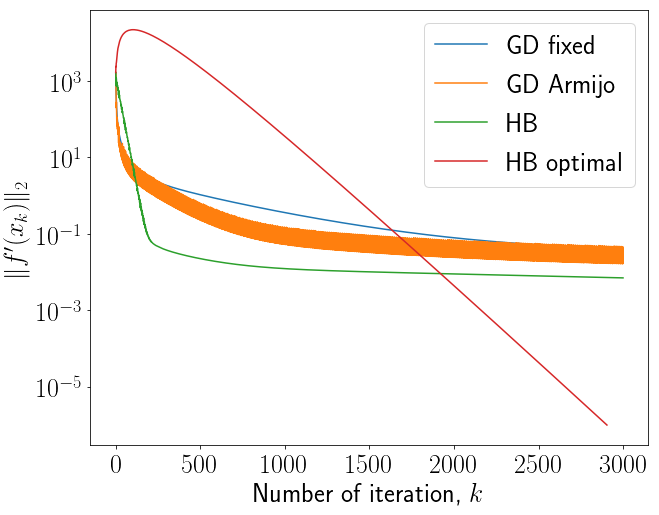

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()][:3000], label=m)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Heavy-ball method highlights

- Simple two-step method
- Converges much faster than GD with appropriate $\alpha_k$, $\beta_k$
- CG is particular case
- Proof only for $\mu$-strongly convex functions

## Nesterov accelerated methods (Nesterov, 1983)

One of possible notation variant

\begin{equation*}
\begin{split}
& y_0 = x_0 \\
& x_{k+1} = y_k - \alpha_k f'(y_k)\\
& y_{k+1} = x_{k+1} + \frac{k}{k + 3} (x_{k+1} - x_k)
\end{split}
\end{equation*}

- Heavy-ball comparison
- ODE interpretation again
- Non-monotone, too
- For those who likes geometry there exists [geometric descent](https://arxiv.org/pdf/1506.08187.pdf) with the same optimal speed of convergence 

### Remarks

- Citation of the original paper by Y. Nesterov

<img src="nesterov_cite.png" width=600>

- Impression of comunity on this method (from [this paper](https://arxiv.org/pdf/1407.1537.pdf))

<img src="lin_coupling_acc.png" width=600>

### Nesterov method visualization

<img src="nesterov_plot.png" width=600>

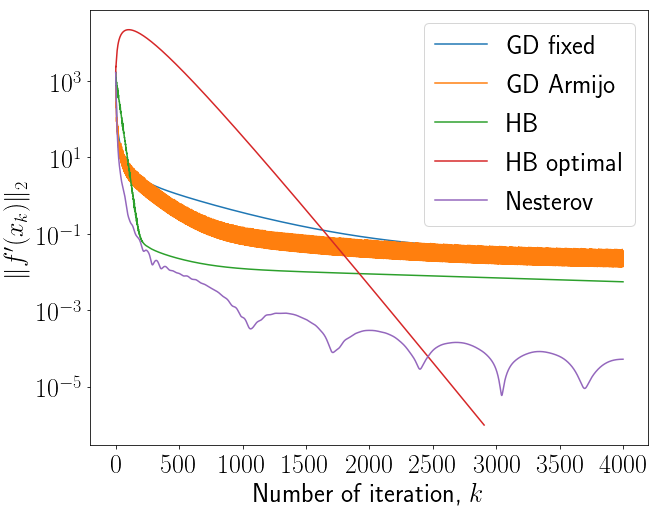

In [53]:
methods["Nesterov"] = fo.AcceleratedGD(f, grad, 
                                       ss.ConstantStepSize(1 / L))
methods["Nesterov"].solve(x0=x0, max_iter=max_iter, tol=tol)
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in 
                  methods[m].get_convergence()[:4000]], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Non-strongly convex case

In [54]:
n = 50
r = 30
A = np.random.randn(r, n)
A = A.T.dot(A)
x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
print(L, mu)

146.65836240975693 -3.478867866097547e-14


In [55]:
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ConstantStepSize(1 / L)),
#     "GD Armijo": fo.GradientDescent(f, grad, 
#             ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    "HB": HeavyBall(f, grad, ss.ConstantStepSize(1 / L), beta=0.5),
    "Nesterov": fo.AcceleratedGD(f, grad, ss.ConstantStepSize(1 / L))
}
x0 = np.random.randn(n)
max_iter = 5000
tol = 1e-6

In [56]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

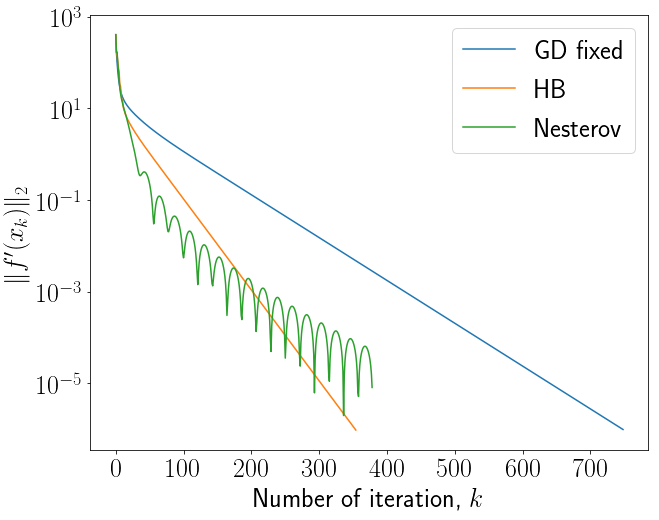

In [57]:
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in 
                  methods[m].get_convergence()[:3000]], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Nesterov accelerated method hightlights

- Optimal w.r.t. theoretical bounds
- Non-monotone, but [restarts](https://arxiv.org/pdf/1204.3982.pdf) can be useful
- Parameters tuning can be not so easy ($L$ and $\mu$ are unknown)
- Deep learning applications (see [Chapter 8 in Deep learning book](https://www.deeplearningbook.org/contents/optimization.html))
- Stochastic generalization

## Adaptive choice of $L$

- In accelerated gradient method step size is equal $\frac{1}{L}$, where $L$ is a Lipschitz constant of gradient
- But it is usually unknown
- But we have descent lemma

$$
f(y) \leq f(x) + \langle f'(x), y - x \rangle + \frac{L}{2}\|x - y\|_2^2
$$

- Analogue of Armijo rule and related schemes

```python
def backtracking_L(f, h, grad, x, L0, rho):
    
    L = L0
    
    fx = f(x)
    
    gradx = grad(x)
    
    while True:
        
        y = x - 1 / L * h
        
        if f(y) <= fx - 1 / L * gradx.dot(h) + 1 / (2 * L) * h.dot(h):
            
            break
            
        else:
            
            L = L * rho
            
    return L
```

## Experiments

In [58]:
beta_test = 0.9
methods = {
    "GD Armijo": fo.GradientDescent(f, grad, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    r"HB, $\beta = {}$".format(beta_test): HeavyBall(f, grad, ss.ConstantStepSize(1 / L), beta=beta_test),
    "Nesterov": fo.AcceleratedGD(f, grad, ss.ConstantStepSize(1 / L)),
    "Nesterov adaptive": fo.AcceleratedGD(f, grad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, init_alpha=1)),
}
x0 = np.zeros(n)
max_iter = 2000
tol = 1e-5

In [59]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

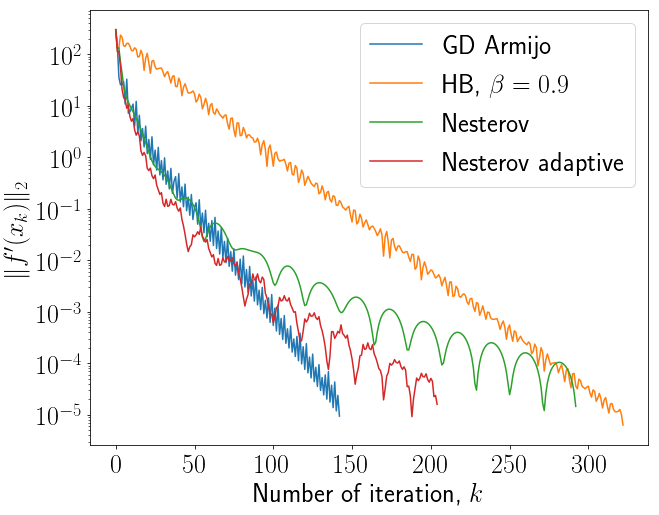

In [60]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [ ]:
for m in methods:
    print(m)
    %timeit methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

## Non-quadratic problem


$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

In [65]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import sklearn.datasets as skldata
n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3, random_state=42)
C = 1

@jax.jit
def f(w):
    return jnp.linalg.norm(w)**2 / 2 +  C * jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))

# def grad(w):
#     denom = scspec.expit(-y * X.dot(w))
#     return w - C * X.T.dot(y * denom) / X.shape[0]

autograd_f = jax.jit(jax.grad(f))
x0 = jnp.ones(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(jnp.linalg.norm(autograd_f(x0))))
%timeit autograd_f(x0)

Initial function value = 162.63079545367793
Initial gradient norm = 18.723119978580637
244 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
beta_test = 0.9
L_trial = (1 + C*100)
methods = {
    "GD Armijo": fo.GradientDescent(f, autograd_f, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.01, init_alpha=1.)),
    r"HB, $\beta = {}$".format(beta_test): HeavyBall(f, autograd_f, ss.ConstantStepSize(1 / L_trial), beta=beta_test),
    "Nesterov": fo.AcceleratedGD(f, autograd_f, ss.ConstantStepSize(1 / L_trial)),
    "Nesterov adaptive": fo.AcceleratedGD(f, autograd_f, ss.Backtracking(rule_type="Lipschitz", rho=0.5, init_alpha=1)),
}
max_iter = 2000
tol = 1e-6

In [68]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

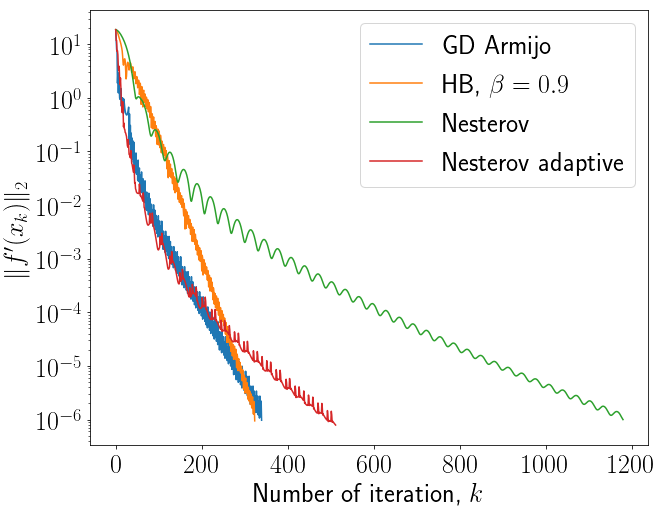

In [69]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(autograd_f(x)) for x in methods[m].get_convergence()], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [70]:
for m in methods:
    print(m)
    %timeit methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

GD Armijo
3.58 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
HB, $\beta = 0.9$
396 ms ± 9.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Nesterov
2.62 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Nesterov adaptive
9.49 s ± 666 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Summary on adaptive choice of $L$

- It works quite good
- But it is more time consuming since the adatation step is performed